# EDA and Data Pre-processing

In [1]:
# Let us import some of the basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings
import pickle
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import os
import distance
from scipy import stats
import re
import time
import ast
from scipy.sparse import csr_matrix
import string
from collections import Counter

In [17]:
from sklearn.feature_extraction.text import CountVectorizer # Tried this but got an accuracy of 69% :(
from sklearn.feature_extraction.text import TfidfVectorizer # Applied this and got the accuracy of 81.4%! :D
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [3]:
import nltk
nltk.download('punkt') #install 'punkt'

[nltk_data] Downloading package punkt to C:\Users\Anubhav
[nltk_data]     Bhatti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
train_df = pd.read_json(r"D:\OneDrive - Queen's University\ECE\Statistical Learning\Final\train.json\train.json")
test_df = pd.read_json(r"D:\OneDrive - Queen's University\ECE\Statistical Learning\Final\test.json\test.json")

In [5]:
#Check Maximum and Minimum number of ingredients in a dish 

print('Maximum Number of Ingredients in a Dish: ',train_df['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Dish: ',train_df['ingredients'].str.len().min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


In [6]:
"""
Provides functions for removing unwanted noise from text.
"""
# Code is inspired from Git hub repo:
# https://github.com/rfliegerallison/kaggle-whats-cooking/blob/master/What's%20Cooking%20-%20Kaggle%20Competition.ipynb
# Please note that more data cleaning has been done (modified and added more words) than the code provided above in the below
# code

# Remove Special Charater exceptions first since, we would not be able to spot them after we remove special characters.
character_exceptions_to_remove = ["\xae", "\xe8vre", "\u2122", "\xada", "\xadn", "¬s", "Ã£", "Ã", "£"]

# Removing some of the phrases with a single word without spaces. 
phrase_exceptions = [("7 up", "sevenup"), ("sun dried", "sundried"), 
                     ("bone less", "boneless"), ("skin less", "skinless")]

# Handling plural values in the dataset
deal_plural_singular = [("steaks", "steak"), ("loins", "loin"), ("inches", "inch"), ("centimeters", "centimeter"),
                          ("ounces", "ounce"), ("liters", "liter"), ("mililiters", "mililiter"), ("grams", "gram"),
                          ("cups", "cup"), ("gallons", "gallon"), ("quarts", "quart"), ("lbs", "lb"),
                          ("pounds", "pound"), ("tablespoons", "tablespoon"), ("teaspoons", "teaspoon"), 
                          ("pints", "pint"), ("fluid ounces", "fluid ounce"), ("onions", "onion"), 
                          ("cloves", "clove"), ("bulbs", "bulb"), ("peppers", "pepper"), ("breasts", "breast"),
                          ("eggs", "egg"), ("carrots", "carrot"), ("mushrooms", "mushroom"),
                          ("tortillas", "tortilla"), ("sausages", "sausage"), ("wedges", "wedge"), 
                          ("tomatoes", "tomato"), ("thighs", "thigh"), ("chilies", "chili"), ("potatoes", "potato"), 
                          ("peppercorns", "peppercorn"), ("spices", "spice"), ("chiles", "chile"), ("apples", "apple"),
                          ("legs", "leg"), ("doughs", "dough"), ("drumsticks", "drumstick")]

# Removing Brand names in the dataset. This is important since same ingredient can be from different brands.
brandnames_to_remove = ["Lea & Perrins", "Lea and Perrin", "Lea and Perrins", "alexia", "breakstones", 
                        "kraft", "bertolli classico", "bertolli", "best foods", 
                        "betty crocker", "bisquick", "bob evans", "breyers", "curry guy", "camellia", "campbells", 
                        "country crock", "crisco", "crystal farms", "delallo", "diamond crystal", "domino", 
                        "doritos", "earth balance", "egglands best", "foster farms", "franks", "gold medal", 
                        "goya", "green giant steamers niblets", "green giant", "heinz", "hellmanns", "herdez", 
                        "hidden valley", "honeysuckle white", "jacksonville",  "jimmy dean", "johnsonville", 
                        "knorr", "krudsen", "kikkoman", "lipton", "land o lakes", "mazola", "lea and perrins", 
                        "mccormick", "meyer", "mission", "old el paso", "old bay", "pam", "pepperidge farm", 
                        "oscar mayer", "pace", "pillsbury", "progresso", "pure wesson", "pompeian", "san marzano", 
                        "sargento", "soy vay", "taco bell", "yoplait", "spice islands", "stonefire", "success", 
                        "swanson", "truvía", "uncle bens", "wish bone", "zatarains", "morton", "jameson", "tapatio", 
                        "mountain high", "philadelphia", "king arthur", "roma", "wolf brand", "tabasco"]

# Removing certain key words that do not add any valuavle information to the ingredient.
keywords_to_remove = ["drained and chopped", "lowfat", "light", "shredded", "sliced", "all purpose", "all natural", "natural", "original", 
                      "gourmet", "traditional", "boneless", "skinless", "fresh", "nonfat", "pitted", "quick cooking", 
                      "unbleached", "part skim", "skim", "quickcooking", "oven ready", "homemade", "instant", "small", 
                      "extra large", "large", "chopped", "grated", "cooked", "stone ground", "freshly ground", 
                      "ground", "pure", "peeled", "deveined", "organic", "cracked", "granulated", "inch thick", 
                      "extra firm", "crushed", "flakes", "self rising", "diced", "crumbles", "crumbled", 
                      "whole wheat", "whole grain", "baby", "medium", "plain", "of", "thick cut", "cubed", "coarse", 
                      "free range", "seasoned", "canned", "multipurpose", "vegan", "thawed", "squeezed", 
                      "vegetarian", "fine", "zesty", "halves", "firmly packed", "drain", "drained", "washed"]

# Removing measurements as this would not add any information
measurements_to_remove = ["in", "inch", "cm", "centimeter", "oz", "ounce", "l", "liter", "ml", "mililiter", "g", 
                          "gram", "cup", "gallon", "quart", "lb", "pound", "tbsp", "tablespoon", "tsp", "teaspoon", 
                          "pint", "fl oz", "fluid ounce"]

phrases_to_remove = measurements_to_remove + keywords_to_remove + brandnames_to_remove

# Mapping different phrases used to for the same ingredients
phrases_to_map = [
    (("green onion", "red onion", "purple onion", "yellow onion", "yel onion"), "onion"),
    (("collard green leaves", "collards", "collard leaves"), "collard greens"),
    ("black pepper", "pepper"),
    ("yel chives", "chives"),
    ("spinach leaves", "spinach"),
    ("tea leaves", "tea"),
    ("chile", "chili"),
    (("garlic clove", "garlic bulb"), "garlic"),
    ("uncooked", "raw"),
    (("red chili pepper", "hot chili pepper", "red hot chili pepper"), "chili pepper"),
    (("baking potato", "baked potato"), "baked potato"),
    (("sea salt", "kosher salt", "table salt", "white salt", "sea salt flakes"), "salt"),
    ("scotch whiskey", "scotch"),
    (("i cant believe its not butter spread", "i cant believe its not butter", "softened butter", "melted butter", "salted butter"), "butter"),
    (("extra virgin olive oil", "virgin olive oil"), "olive oil"),
    (("white bread", "wheat bread", "grain bread"), "bread"),
    (("white sugar", "yel sugar"), "sugar"),
    ("confectioners sugar", "powdered sugar"), 
    (("whole wheat spaghetti noodles", "whole wheat spaghettini"), "whole wheat spaghetti"),
    ("white tuna in water", "white tuna"), (("white bread slices", "white bread crumbs"), "white bread"), 
    (("whipped cream", "whipped topping", "whipping cream", "whipping heavy cream", "whipped topping"), "whipped cream"),
    ("water chestnut powder", "water chestnuts"), (("walnut halves", "walnut pieces"), "walnuts"), 
    ("waffle fries", "waffle"), ('deli ham', 'ham'), ('taco seasoning mix', 'taco seasoning'),("chees", "cheese"), ("sauc", "sauce"),
    ("paneer cheese", "paneer"), ("aleppo", "aleppo pepper"), ("all potato purpos", "potato"),
    ("Jamaican allspice", "allspice pepper"), ("allspice", "allspice pepper"),
    ("zucchini blossoms", "zucchini"), ("yukon gold", "yukon gold potatoes"), ("yellowfin", "yellowfin tuna"),
    ("yellow summer squash", "yellow squash"), ("yellow mustard seeds", "yellow mustard"),
    ("whole wheat tortilla wraps", "whole wheat tortilla"), ("vermicelli noodles", "vermicelli"), ("veggies", "vegetables"),
    (("vegetable oil cooking spray", "vegetable oil spray"), "vegetable oil"), 
    (("vegetable soup", "vegetable stock", "vegetable stock powder", "vegetable slaw"), "vegetable broth"), 
    (("vanilla essence", "vanilla flavoring", "vanilla"), "vanilla extract"), ("vanilla bean", "vanilla beans"),
    ("urad dal split", "urad dal"), (("original converted brand rice", "ready rice whole grain brown rice"), "rice"),
    ("turnip greens", "turnips"), ("turmeric root", "tumeric"), (("tortilla wraps", "tortilla shells"), "tortillas"), 
    (("tortelloni", "tortellini, cook and drain"), "tortellini"), ("top sirloin steak", "top sirloin"),
    (("thyme", "thyme leaves", "thyme sprig", "thyme sprigs"), "thyme"), ("spinach leaves", "spinach"), 
    (("spaghetti squash","spaghetti, cook and drain", "spaghettini"), "spaghetti"), ("sliced mushrooms", "mushrooms"), 
    (("sesame", "sesame paste", "sesame seed paste", "toasted sesame seeds", "roasted sesame seeds"), "sesame seeds"), 
    (("dark sesame oil", "toasted sesame oil"), "sesame oil"), ("serrano chilies", "serrano chile"), 
    ("scallion greens", "scallions"), (("saffron powder", "saffron threads"), "saffron")]

# Removind the special characters at last!
replace_punc_space = re.compile(r"[-,]")
remove_percentage_less = re.compile(r"[\d+]% less [A-z]*")
remove_percentage_reduced = re.compile(r"[\d+]% reduced [A-z]*")
remove_special_char = re.compile(r"[!\\/%.'®™Ã£Âº©¢â€žÂ¢â„¢¨â‚¬§]")
remove_digits = re.compile(r"\d+")
replace_symbols_and = re.compile(r"[&+]")
remove_parantheses_content = re.compile(r"\([^)]*\)")
remove_betweeen_no_added = re.compile(r"no [A-z]* added")
reove_reduced_word = re.compile(r"reduced [A-z]*")
remove_low_and_following_word = re.compile(r"low [A-z]*")
remove_less_and_following_word = re.compile(r"less [A-z]*")
remove_free_and_previous_word = re.compile(r"[A-z]* free")
trim_multi_spaces = re.compile(r" +")

In [7]:
# Defining functions to call the above code for data cleaning!

# Code is inspired from Git hub repo:
# https://github.com/rfliegerallison/kaggle-whats-cooking/blob/master/What's%20Cooking%20-%20Kaggle%20Competition.ipynb
# Please note the modification have been made in the code from the above repo before using it in my code.

def clean_column(ingredient):
    
    ingredient = ingredient.lower()
    ingredient = replace_punc_space.sub(" ", ingredient)
    
    # Map certain exceptions that we don't want whiped out by later cleaning processes.
    for character_exception in character_exceptions_to_remove:
        ingredient = re.sub(character_exception, "", ingredient)
    for phrase_exception, replacement in phrase_exceptions:
        ingredient = re.sub(r"\b{}\b".format(phrase_exception), replacement, ingredient)
        
    ingredient = remove_percentage_less.sub("", ingredient)
    ingredient = remove_percentage_reduced.sub("", ingredient)
    ingredient = remove_special_char.sub("", ingredient)
    ingredient = remove_digits.sub("", ingredient)
    ingredient = replace_symbols_and.sub(" and ", ingredient)
    ingredient = remove_parantheses_content.sub(" ", ingredient)
    ingredient = remove_betweeen_no_added.sub("", ingredient)
    ingredient = reove_reduced_word.sub("", ingredient)
    ingredient = remove_low_and_following_word.sub("", ingredient)
    ingredient = remove_less_and_following_word.sub("", ingredient)
    ingredient = remove_free_and_previous_word.sub("", ingredient)
    ingredient = trim_multi_spaces.sub(" ", ingredient)

    for plural, singular in deal_plural_singular:
        ingredient = re.sub(r"\b{}\b".format(plural), singular, ingredient)

    for phrase in phrases_to_remove:
        ingredient = re.sub(r"\b{}\b".format(phrase), "", ingredient)
    
    for pattern, replacement in phrases_to_map:
        if type(pattern) is tuple:
            for val in pattern:
                ingredient = re.sub(r"\b{}\b".format(val), replacement, ingredient)
        elif type(pattern) is str:
            ingredient = re.sub(r"\b{}\b".format(pattern), replacement, ingredient)
    
    ingredient = trim_multi_spaces.sub(" ", ingredient)
    ingredient = ingredient.strip()
    return ingredient

def clean_recipe(recipe):
    recipe = list(map(clean_column, recipe))
    recipe = [ingredient for ingredient in recipe if len(ingredient) > 0]
    return recipe

def clean_raw_data(raw_data):
    clean_data = raw_data['ingredients'].apply(clean_recipe)
    return clean_data

In [8]:
# Storing the clean ingredients back to train and test dataset!

train = clean_raw_data(train_df)
test = clean_raw_data(test_df)

train_df['ingredients'] = train
test_df['ingredients'] = test

In [9]:
type(train_df['ingredients'][0])

list

In [10]:
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)
test_df['seperated_ingredients'] = test_df['ingredients'].apply(','.join)

Text(0.5, 1.0, 'Ingredients in a Dish Distribution')

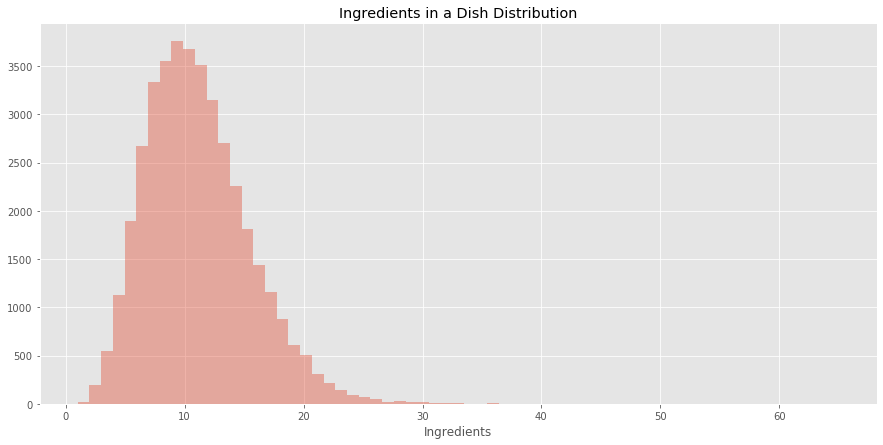

In [15]:
# Let's see the distribution of ingredient length

fig, ax1 = plt.subplots()
fig.set_size_inches(15, 7)

sns.distplot(train_df['ingredients'].str.len(),bins=max(train_df['ingredients'].str.len()), 
             kde=False, axlabel='Ingredients')
# plt.hist(train_df['ingredients'].str.len(),bins=max(train_df['ingredients'].str.len()),edgecolor='b')
plt.title('Ingredients in a Dish Distribution')

Text(0.5, 1.0, 'Cuisine Distribution')

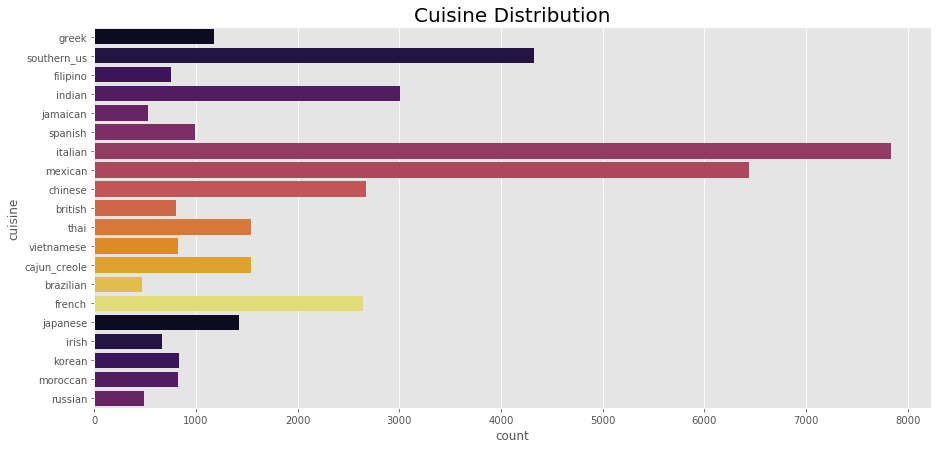

In [16]:
sns.countplot(y='cuisine', data=train_df, palette=sns.color_palette('inferno', 15))
plt.gcf().set_size_inches(15,7)
plt.title('Cuisine Distribution', size=20)

In [35]:
def word_dict():
    ingre_dt = {}
    for row in range(len(train_df)):
        for inc in range(len(train_df['ingredients'].values[row])):
            if train_df['ingredients'].values[row][inc] not in ingre_dt:
                ingre_dt[train_df['ingredients'].values[row][inc]] = 1
            else:
                ingre_dt[train_df['ingredients'].values[row][inc]] = ingre_dt[train_df['ingredients'].values[row][inc]] + 1
    return ingre_dt

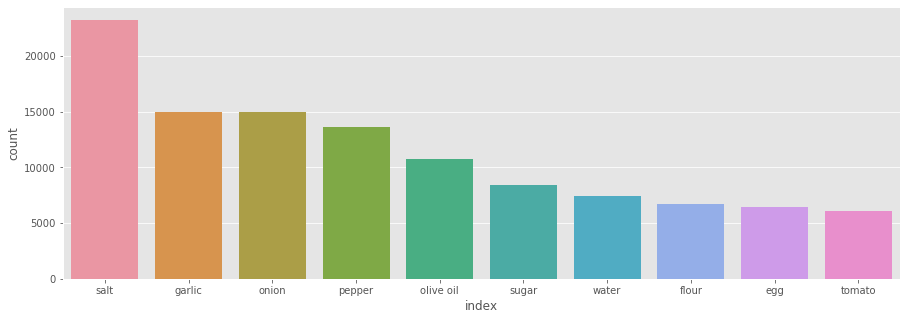

In [36]:
# plotting top ten ingredients in all cuisines
wrd_dict = word_dict()
wrd_plot = pd.DataFrame.from_dict(wrd_dict, orient = 'index', columns=['count']).reset_index()
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 5)

sns.barplot(x='index', y = 'count', data=wrd_plot.sort_values(by=['count'], ascending=False)[:10], ax = ax1)

In [50]:
# Pickling the training and test dataset so, that we can use it other files for training our model.

pickle.dump(train_df, open("train_df.pkl", "wb"))
pickle.dump(test_df, open("test_df.pkl", "wb"))

In [3]:
# Loading the pickle files!
train_df = pickle.load(open(r'train_df.pkl', 'rb'))
test_df = pickle.load(open(r'test_df.pkl', 'rb'))

In [18]:
# Using the TFid Vectorizer instead of Count Vectorizer since, count vectorizer did not perform well on the test dataset 
# even after performing all the data cleaning for hours!

vect = TfidfVectorizer(binary=True).fit(train_df['seperated_ingredients'].values)
X_train_vectorized = vect.transform(train_df['seperated_ingredients'].values)
X_train_vectorized = X_train_vectorized.astype('float')
Result_transformed = vect.transform(test_df['seperated_ingredients'].values)
Result_transformed = Result_transformed.astype('float')

In [20]:
# Lisitng the parameters of the vectorizer

vect

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
print(X_train_vectorized.shape)

(39774, 2811)


In [22]:
print(Result_transformed.shape)

(9944, 2811)


In [50]:
print(X_train_vectorized[0])

  (0, 167)	0.22621776458221407
  (0, 224)	0.2393211443585159
  (0, 488)	0.15826297502552586
  (0, 887)	0.3314812278835899
  (0, 1007)	0.4236034505026212
  (0, 1013)	0.11481702935361618
  (0, 1085)	0.3819340006970674
  (0, 1417)	0.29043363152489127
  (0, 1739)	0.284570292652213
  (0, 1743)	0.12077625394858096
  (0, 1858)	0.10814801110620453
  (0, 2139)	0.37359935919931186
  (0, 2241)	0.2508479651597488
  (0, 2589)	0.1549564465503938


In [23]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df.cuisine)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed, random_state = 0)

# Training Logistic Regression

In [25]:
# Training the Logistic Regression with default parameters
clf1 = LogisticRegression(C=10,dual=False)
clf1.fit(X_train , y_train)
clf1.score(X_test, y_test)

# Seems it is doing well on the validation dataset 
# Let's try it on the test dataset now!

0.7934432823813354

In [27]:
# Predicting on test dataset with Logistic Regression with default parameters
clf1.fit(X_train_vectorized, y_transformed)
y_predicted = clf1.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
predictions = predictions[[ 'id' , 'cuisine']]
predictions.to_csv('submit_LR_default.csv', index = False) # Kaggle Score 0.78751! Not bad!
# I will try to fine tune the parameter 'C' for Logistic Regression now.

For Grid Search code, please refer to notebook named "Grid Search Logistic Regression.ipynb"

In [28]:
# Now, let's try with optimized parameters from Grid Search 'Enter the name of the File' for Logistic Regression
clf1 = LogisticRegression(C = 4.281332398719396, penalty = 'l2', solver = 'liblinear' , dual=False)
clf1.fit(X_train , y_train)
clf1.score(X_test, y_test)

0.7944489139179405

In [29]:
# Predicting on test dataset with Logistic Regression with grid parameters
clf1.fit(X_train_vectorized, y_transformed)
y_predicted = clf1.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
predictions = predictions[[ 'id' , 'cuisine']]
predictions.to_csv('submit_LR_best.csv', index = False) # Kaggle Score 0.78841! okay! -_-

# Training SVC

In [30]:
# Training with random parameters

clf2 = SVC(C=100, gamma=1, kernel='rbf')
clf2.fit(X_train , y_train)
clf2.score(X_test, y_test)

0.8111423974255833

In [31]:
clf2.fit(X_train_vectorized, y_transformed)
y_predicted = clf2.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine': y_predicted_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]
predictions.to_csv('submit_SVC_random.csv', index = False) # kaggle score 0.80812! great!

# For Grid Search prediction please refer the notebook named "Grid Search SVC.ipynb"

For Grid Search code, please refer to notebook named "Grid Search SVC.ipynb"

In [32]:
clf2 = SVC(C= 10, gamma= 1, kernel= 'rbf', verbose = 1) # Grid Search parameters
clf2.fit(X_train , y_train)
clf2.score(X_test, y_test)

[LibSVM]

0.8118463395012068

In [33]:
clf2.fit(X_train_vectorized, y_transformed)
y_predicted = clf2.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine': y_predicted_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]
predictions.to_csv('submit_SVC_best_grid_params.csv', index = False) # kaggle score 0.80842! great!
# Now, I can select these parameters for my voting classifier!

[LibSVM]

# Training SGD Classifier

In [38]:
clf3 = SGDClassifier(n_jobs=-1) # default parameters

clf3.fit(X_train , y_train)
clf3.score(X_test, y_test)

0.7823813354786806

In [39]:
clf3.fit(X_train_vectorized, y_transformed)
y_predicted = clf3.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine': y_predicted_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]
predictions.to_csv('submit_SGD_default.csv', index = False) # kaggle score 0.77373!

# Let's fine tune it a little bit.
# For Grid Search please refer the notebook named "Grid Seearch SGD.ipynb"

For Grid Search code, please refer to notebook named "Grid Seearch SGD.ipynb"

In [41]:
clf3 = SGDClassifier(alpha = 4e-05, loss = 'hinge', max_iter = 1000, n_jobs = -1, penalty = 'l2') # Grid parameters

clf3.fit(X_train , y_train)
clf3.score(X_test, y_test)

0.7871078037007241

In [42]:
clf3.fit(X_train_vectorized, y_transformed)
y_predicted = clf3.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine': y_predicted_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]
predictions.to_csv('submit_SGD_best_grid_params.csv', index = False) # kaggle score 0.78077!

# Training with Neural Networks!

#### I have also trained the neural networks for prediction. Since, GPU was required to train the nets, I used Google's Colaboratory for training and prediction. 

#### The code along with the results can be found in the file name "Neural Networks for What's Cooking.ipynb"

For Neural Networks, I trained five different networks with different arhitecture i.e., with different nodes, hidden layers, droupout values, regularization values, and early stopping. However, the performance I could get was from the simplest model i.e., neural network 1

### (kaggle score of 0.77051) 

# Training Random Forest Classifier

In [43]:
clf4 = RandomForestClassifier(verbose = 1)
clf4.fit(X_train , y_train)
clf4.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0.7039420756234915

For Grid Search code, please refer to notebook named "Grid Seearch Random Forest.ipynb"

In [44]:
# Training with Grid Search parameters
best_params = {'bootstrap': 'True', 'criterion': 'gini', 'max_depth': None,
               'max_features': 'auto', 'min_samples_split': 3,'n_estimators': 800}

clf4 = RandomForestClassifier(**best_params)
clf4.fit(X_train_vectorized, y_transformed)
y_predicted = clf4.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine': y_predicted_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]
predictions.to_csv('submit_RF_best_grid_params.csv', index = False) # kaggle score 0.75955!

# Training Decision Tree Classifier with OneVsRest Classifier

In [45]:
clf5 = OneVsRestClassifier(DecisionTreeClassifier())

clf5.fit(X_train , y_train)
clf5.score(X_test, y_test)

0.5990547063555913

In [46]:
clf5.fit(X_train_vectorized, y_transformed)
y_predicted = clf5.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine': y_predicted_final, 'id': test_df.id})
predictions = predictions[['id', 'cuisine']]
predictions.to_csv('submit_DT_default.csv', index = False) # kaggle score 0.60166!

# Training with VotingClassifier and using best parameters of SVC, SGD, and Logistic Regressor (Best kaggle score for me)

In [25]:
Best_vclf = VotingClassifier(estimators=[('clf1', LogisticRegression(C=10,dual=False, multi_class= 'ovr')),
                                       ('clf2', OneVsRestClassifier(SVC(C= 10, gamma= 1, kernel= 'rbf', 
                                                                        probability=True))), 
                                       ('clf3', SGDClassifier(alpha = 4e-05, loss = 'log', max_iter = 1000, 
                                                              n_jobs = -1, penalty = 'l2', verbose = 1))],
                           voting='soft',weights=[1,2,3])

Voting_clf_best = Best_vclf.fit(X_train_vectorized, y_transformed)

y_predicted = Best_vclf.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
predictions = predictions[[ 'id' , 'cuisine']]
predictions.to_csv('submit_votingclf_best.csv', index = False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 20.32, NNZs: 2811, Bias: -3.472103, T: 39774, Avg. loss: 0.041581Norm: 24.91, NNZs: 2811, Bias: -3.544685, T: 39774, Avg. loss: 0.072164

Total training time: 0.02 seconds.
Total training time: 0.02 seconds.
-- Epoch 2
-- Epoch 2
Norm: 29.62, NNZs: 2811, Bias: -3.043829, T: 39774, Avg. loss: 0.073306
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 24.42, NNZs: 2811, Bias: -3.509914, T: 39774, Avg. loss: 0.055574
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 28.08, NNZs: 2811, Bias: -3.270309, T: 39774, Avg. loss: 0.084943
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 23.22, NNZs: 2811, Bias: -3.003041, T: 39774, Avg. loss: 0.063971
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 30.82, NNZs: 2811, Bias: -2.446051, T: 39774, Avg. loss: 0.146431
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 24.30, NNZs: 2811, Bias: -3.431236, T: 39774, Avg. loss: 0.055127
Total training

Total training time: 0.05 seconds.
-- Epoch 4
Norm: 19.33, NNZs: 2811, Bias: -3.767835, T: 119322, Avg. loss: 0.038080-- Epoch 4Norm: 21.50, NNZs: 2811, Bias: -4.159758, T: 159096, Avg. loss: 0.026845

Total training time: 0.04 seconds.
-- Epoch 4

Total training time: 0.06 seconds.
-- Epoch 5
Norm: 37.57, NNZs: 2811, Bias: -1.605602, T: 159096, Avg. loss: 0.156366
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 20.96, NNZs: 2811, Bias: -3.540181, T: 198870, Avg. loss: 0.043501
Total training time: 0.08 seconds.
-- Epoch 6
Norm: 26.40, NNZs: 2811, Bias: -2.877736, T: 159096, Avg. loss: 0.056953
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 22.89, NNZs: 2811, Bias: -3.998766, T: 159096, Avg. loss: 0.033094
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 19.30, NNZs: 2811, Bias: -3.838502, T: 159096, Avg. loss: 0.037886
Norm: 35.46, NNZs: 2811, Bias: -2.617656, T: 159096, Avg. loss: 0.094673
Total training time: 0.07 seconds.
-- Epoch 5
Total training time: 0.06 seconds.
--

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


# With the Voting Classifier, I could get the best score of 0.81074!